# 성능 향상 튜토리얼

작성자: 심소연

작성일: 2022-04-06

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

In [4]:
import warnings
warnings.filterwarnings('ignore')

sns.set(style='white', context='notebook', palette='deep')

In [5]:
df_train_orig = pd.read_csv('train.csv')
df_test_orig = pd.read_csv('test.csv')

df_train = pd.read_csv('train_ticket.csv')
df_test = pd.read_csv('test_ticket.csv')

## 1. 이전 주에서는 생각하지 못했던 전처리 과정

### 1. Cabin

결측치가 많았으나, 이 항목을 학습에 제외하지 않는 대신 많은 결측치를 하나의 'X' 로 분류하였다.

<AxesSubplot:xlabel='Cabin', ylabel='count'>

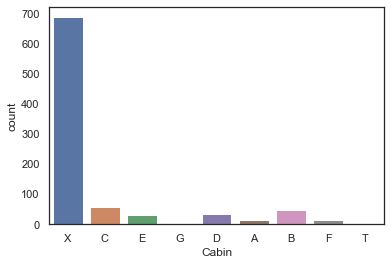

In [6]:
# pandas Series
# https://nittaku.tistory.com/110
# { "key" : value, ... }

# pandas DataFrame
# { "column name" : [ value, ... ], ... }

df_train_orig['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df_train_orig['Cabin']])
df_test_orig['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in df_test_orig['Cabin']])
sns.countplot(df_train_orig['Cabin'])

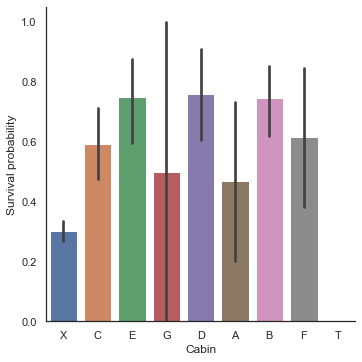

In [7]:
# Cabin 의 첫 글자에 따른 생존률 차이를 확인하는 과정
# 미확인된 경우에서보다 확인된 경우에서 생존률이 더 높음을 확인할 수 있었다.

g = sns.factorplot('Cabin', 'Survived', data=df_train_orig, kind='bar')
g.set_ylabels('Survival probability')

### 2. Ticket

저자는 (Yassine Ghouzam, <Titanic Top 4% with ensemble modeling>) Ticket 문자열을 ' ' 을 기준으로 분할하여, 

앞 부분에 위치한 숫자가 아닌 문자를 이용하고자 하였다.

In [8]:
def makeTicket(df):
    ticket = []
    for i in list(df.Ticket):
        if not i.isdigit():
            ticket.append(i.replace('.', '').replace('/','').strip().split(' ')[0])
        else:
            ticket.append('X')
    return ticket

df_train_orig['Ticket'] = makeTicket(df_train_orig)
df_test_orig['Ticket'] = makeTicket(df_test_orig)

In [9]:
# 이전에 전처리한 데이터에서 Ticket_{:d} 제거

# title 의 영향 
# (이미 Sex 와 연관이 있어 보이는데, 중복된 자료라 생각돼 이로 인한 부정적인 영향은 없을지 궁금함)

df_train.drop(['Ticket_{:d}'.format(i) for i in range(0, 10)], axis=1, inplace=True)
df_test.drop(['Ticket_{:d}'.format(i) for i in range(0, 10)], axis=1, inplace=True)

In [10]:
# 오늘 전처리한 부분 추가

df_train['Ticket'] = df_train_orig['Ticket']
df_test['Ticket'] = df_test_orig['Ticket']

df_train['Cabin'] = df_train_orig['Cabin']
df_test['Cabin'] = df_test_orig['Cabin']

In [11]:
# one-hot encoding

df_train = pd.get_dummies(df_train, columns=['Ticket'], prefix='T')
df_test = pd.get_dummies(df_test, columns=['Ticket'], prefix='T')

df_train = pd.get_dummies(df_train, columns=['Cabin'], prefix='Cabin')
df_test = pd.get_dummies(df_test, columns=['Cabin'], prefix='Cabin')

In [12]:
# column 의 차이 완화

difference = set(df_train.columns) - set(df_test.columns) - {'Survived'}
for col in difference:
    df_test[col] = 0

In [13]:
df_train.drop(['Unnamed: 0'], axis=1, inplace=True)
df_test.drop(['Unnamed: 0'], axis=1, inplace=True)

## 2. Modeling

In [14]:
Y_train = df_train['Survived']
X_train = df_train.drop(labels=['Survived'], axis=1)

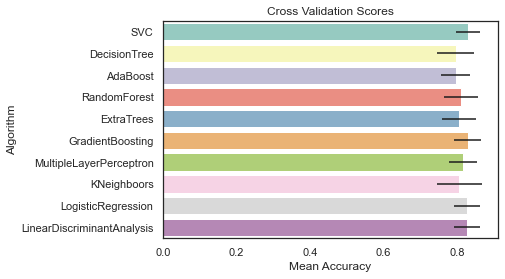

In [15]:
kfold = StratifiedKFold(n_splits=10)
random_state = 2
classifiers = []
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), random_state=random_state, learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state=random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, y=Y_train, scoring='accuracy', cv=kfold, n_jobs=4))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

cv_res = pd.DataFrame({'CrossValMeans': cv_means, 'CrossValerrors': cv_std, 'Algorithm': ["SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","MultipleLayerPerceptron","KNeighboors","LogisticRegression","LinearDiscriminantAnalysis"]})

g = sns.barplot('CrossValMeans', 'Algorithm', data=cv_res, palette='Set3', orient='h', **{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross Validation Scores')

## 3. Hyperparameter Tunning for Best Models

모델 성능 향상을 위한 과정이다.

In [16]:
# AdaBoost

DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)
ada_param_grid = {'base_estimator__criterion': ['gini', 'entropy'],
                 'base_estimator__splitter': ['best', 'random'],
                 'algorithm': ['SAMME', 'SAMME.R'],
                 'n_estimators': [1, 2],
                 'learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 1.5]}

# verbose
# 0 (default) : 메시지 출력 안함
# 1 : 간단한 메시지 출력
# 2 : 하이퍼파라미터 별 메시지 출력

gsadaDTC = GridSearchCV(adaDTC, param_grid=ada_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsadaDTC.fit(X_train, Y_train)
ada_best = gsadaDTC.best_estimator_
gsadaDTC.best_score_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


0.8103245942571784

In [17]:
# ExtraTrees

ExtC = ExtraTreesClassifier()
ex_param_grid = {"max_depth": [None],
                "max_features": [1, 3, 10],
                "min_samples_split": [2, 3, 10],
                "min_samples_leaf": [1, 3, 10],
                'bootstrap': [False],
                'n_estimators': [100, 300],
                'criterion': ['gini']}
gsExtC = GridSearchCV(ExtC, param_grid=ex_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsExtC.fit(X_train, Y_train)
ExtC_best = gsExtC.best_estimator_
gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8350686641697879

In [18]:
# RandomForest

RFC = RandomForestClassifier()
rf_param_grid = {'max_depth': [None],
                'max_features': [1, 3, 10],
                'min_samples_split': [2, 3, 10],
                'min_samples_leaf': [1, 3, 10],
                'bootstrap': [False],
                'n_estimators': [100, 300],
                'criterion': ['gini']}
gsRFC = GridSearchCV(RFC, param_grid=rf_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsRFC.fit(X_train, Y_train)
RFC_best = gsRFC.best_estimator_
gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8384019975031209

In [19]:
# GradientBoosting

GBC = GradientBoostingClassifier()
gb_param_grid = {'loss': ['deviance'],
                'n_estimators': [100, 200, 300],
                'learning_rate': [0.1, 0.05, 0.01],
                'max_depth': [4, 8],
                'min_samples_leaf': [100, 150],
                'max_features': [0.3, 0.1]}
gsGBC = GridSearchCV(GBC, param_grid=gb_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsGBC.fit(X_train, Y_train)
GBC_best = gsGBC.best_estimator_
gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.826079900124844

In [20]:
# SVC

SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'],
                 'gamma': [0.001, 0.01, 0.1, 1],
                 'C': [1, 10, 50, 100, 200, 300, 1000]}
gsSVMC = GridSearchCV(SVMC, param_grid=svc_param_grid, cv=kfold, scoring='accuracy', n_jobs=4, verbose=1)
gsSVMC.fit(X_train, Y_train)
SVMC_best = gsSVMC.best_estimator_
gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8350312109862672

## 4. Plot Learning Curves

과적합 효과와 훈련 크기가 정확도에 미치는 영향을 확인하기 위한 과정이다.

또는, 더 많은 데이터를 학습시켜야 하는지에 대해서도 결정할 수 있다.

In [21]:
# estimator : (3 에서 얻은) 하이퍼파라미터가 잘 튜닝된 학습 모델을 입력함

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Traing Score')
    plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-Validation Score')
    plt.legend(loc='best')
    
    return plt

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

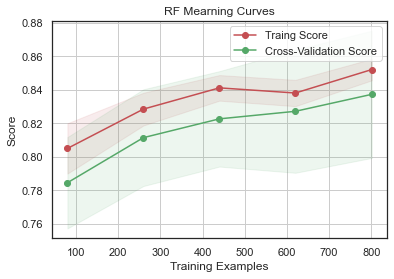

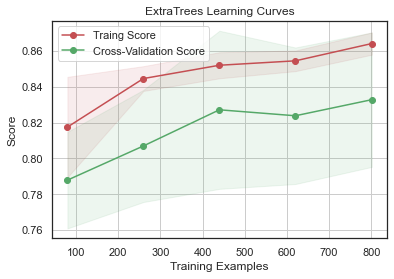

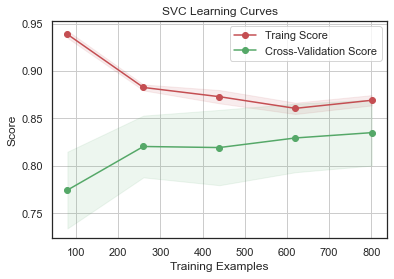

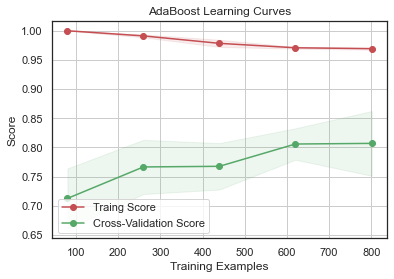

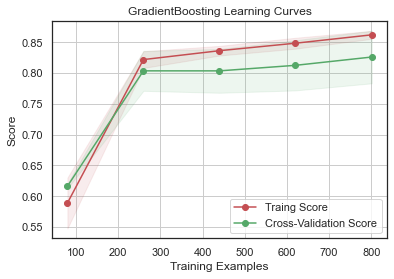

In [22]:

# 참고 
# https://brunch.co.kr/@chris-song/32 

# RF : 더 많은 데이터를 학습시킨다면, 더 좋은 성능을 끌어낼 수 있을 것으로 예상된다.
# SVC : 더 많은 데이터를 학습시킨다면, 더 좋은 성능을 끌어낼 수 있을 것으로 예상된다.
# AdaBoost : training score 이 오히려 점점 감소하고 있어 문제가 발생함을 알 수 있다. 

plot_learning_curve(gsRFC.best_estimator_, 'RF Mearning Curves', X_train, Y_train, cv=kfold)
plot_learning_curve(gsExtC.best_estimator_,"ExtraTrees Learning Curves", X_train, Y_train, cv=kfold)
plot_learning_curve(gsSVMC.best_estimator_,"SVC Learning Curves", X_train, Y_train, cv=kfold)
plot_learning_curve(gsadaDTC.best_estimator_,"AdaBoost Learning Curves", X_train, Y_train, cv=kfold)
plot_learning_curve(gsGBC.best_estimator_,"GradientBoosting Learning Curves", X_train, Y_train, cv=kfold)

## 5. Feature importance

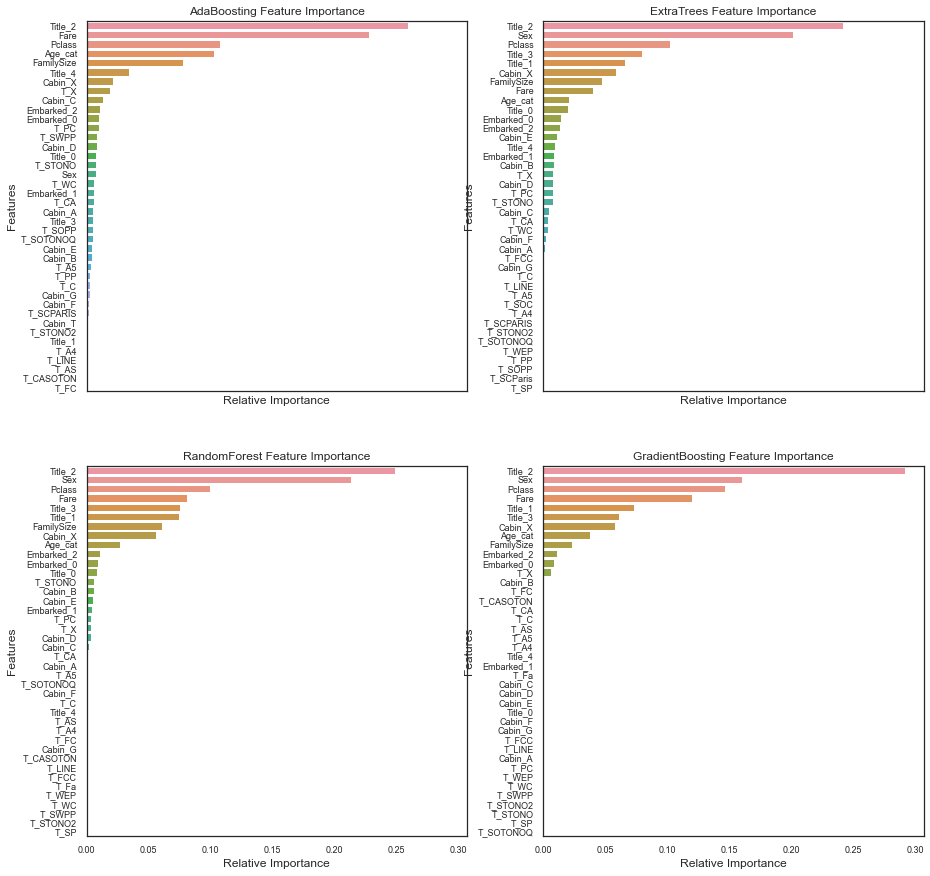

In [23]:
# sharex
# 모든 서브플롯이 같은 x축 눈금을 사용하도록 함

# 각 모델마다 중요한 feature 의 순위는 다르지만, Sex/ Fare/ Pclass 보다도 Title_2 ('Mr') 의 유무가 생존률에 가장 큰 영향을 미쳤음을 알 수 있다.
nrows = ncols = 2

f, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex='all', figsize=(15, 15))
names_classifiers = [('AdaBoosting', ada_best), ('ExtraTrees', ExtC_best), ('RandomForest', RFC_best), ('GradientBoosting', GBC_best)]
nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40], x=classifier.feature_importances_[indices][:40], orient='h', ax=ax[row][col])
        g.set_xlabel('Relative Importance', fontsize=12)
        g.set_ylabel('Features', fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name + ' Feature Importance')
        nclassifier += 1